In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

from scipy.spatial.distance import cdist
import cv2
from scipy.stats import norm
import time

from IPython import display

np.random.seed(0)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import torch

In [2]:
class grid_env():
    # note the array is flipped when plotted
    def __init__(self,sparse=True,model=None, move_penalty=0.0, goal_reward=1.0, collision_penalty=0.0):
        self.N = 20 # sidelength of the grid map
        
        x = np.arange(self.N) # create x coord array
        y = np.arange(self.N) # create y coord array

        self.xx,self.yy = np.meshgrid(x,y) # create matrices of x and y coords, as separate matrices, that can be served as input to 
        # some multidimensional function

        # create an occupancy map
        self.occ_map = np.zeros((self.N,self.N))
        # create a small hollow box in the middle of the map, with value 1, size 7x7, and a small opening
        self.occ_map[6:14,6:14] = 1
        self.occ_map[7:13,7:13] = 0
        # add the small 2-pixel opening on the right side of the box
        self.occ_map[8:10,13] = 0

        # goal location
        self.xl = 11 
        self.yl = 9
        
        # reward
        self.fv = lambda x,y : np.exp(-1*((x-self.xl)**2+(y-self.yl)**2)) # e^(-dist^2). gaussian proximity reward function
        if sparse:
            self.f = self.fv(self.yy, self.xx) # reward vector
        #else:
            #real_valued_states = torch.arange(-2.0, 2.01, 0.01).unsqueeze(1)
            #rewards = model.predict_reward(real_valued_states)
            #self.f = rewards[:, 0].detach().numpy()

        # random initial location outside the box
        # continually attempt to find a random initial location outside the box until one is found
        self.state = self.search_for_free_state()
        
        self.action_space = np.array([[0,1],[0,-1],[-1,0],[1,0]]) # up down left right
        self.move_penalty = move_penalty
        self.collision_penalty = collision_penalty
        self.goal_reward = goal_reward
        
    def search_for_free_state(self):
        while True:
            x0 = np.random.randint(self.N)
            y0 = np.random.randint(self.N)
            if self.occ_map[x0,y0] == 0:
                break
        return np.array([x0,y0])
    # apply action and update the state
    def mm(self,X,u):
        collision = False
        x = X[0] + u[0]
        y = X[1] + u[1]
        # if the new state is at an obstacle or out of the map, stay at the same state
        if x < 0 or x > self.N-1 or y < 0 or y > self.N-1 or self.occ_map[x,y] == 1:
            collision = True
            return X, collision
        else:
            return np.array([x,y]), collision
    
    # step one interaction
    def step(self,idx):
        u = self.action_space[idx,:]
        new_state, collision = self.mm(self.state,u)
        self.state = np.copy(new_state)
        # compute reward
        reward = self.f[new_state[0],new_state[1]]
        # subtract movement penalty
        reward = reward - self.move_penalty
        # subtract collision penalty
        if collision:
            reward = reward - self.collision_penalty
        # return new state, gaussian proximity reward
        return self.state, reward
    
    def reset(self):
        self.state = self.search_for_free_state()
        return np.copy(self.state)
    
    def plot(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.occ_map.T, origin="lower", cmap='gray')
        plt.plot(self.state[0],self.state[1],'ro') # agent location
        plt.plot(self.xl,self.yl,'gx') # goal location
        plt.axis('off')
        plt.show()

    def plot_reward(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.f.T, origin="lower", cmap='gray')
        plt.plot(self.state[0],self.state[1],'ro')

    def plot_reward_and_trajectory(self, trajectory):
        plt.figure(figsize=(5,5))
        plt.imshow(self.f.T, origin="lower", cmap='gray')
        plt.plot(self.state[0],self.state[1],'ro')
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-')

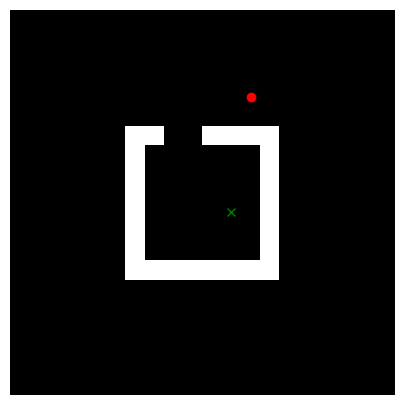

In [3]:
env = grid_env(sparse=True)
env.plot()


In [8]:
def value_iteration(env,init=None,iters=10000,alpha=0.9,gamma=0.9,final_greediness=0.5,eps_anneal=True,plot_freq=1,disp=True):
    
    if init is None:
        Q = np.ones((env.N*env.N,env.action_space.shape[0])) # initialise Q table
    else:
        Q = init
    reward = 0
    if disp:
        plt.figure(figsize=(15,5))
    xm = []
    rewards = []
    for j in range(iters):
        state = np.copy(env.state)
        
        # Epsilon-greedy
        if eps_anneal:
            greediness = final_greediness*np.exp(1-iters/(j+1)) # asymptotically rising exponential to the final greediness
        else:
            greediness = final_greediness
            
        if np.random.rand() < greediness:
            a = np.argmax(Q[env.N*state[0]+state[1],:])
        else:
            a = np.random.randint(env.action_space.shape[0])

        new_state, new_reward = env.step(a)
        xm.append(np.copy(new_state))

        new_a = np.argmax(Q[env.N*new_state[0]+new_state[1],:])
        Qmax = Q[env.N*new_state[0]+new_state[1],new_a]
        Q[env.N*state[0]+state[1],a] = (1-alpha)*Q[env.N*state[0]+state[1],a] + alpha*(reward + gamma*Qmax)
        reward = new_reward
        
        rewards.append(reward)
        
        if (j %plot_freq == 0) and (disp):
            plt.subplot(2,3,1)
            plt.imshow(env.f.T,origin='lower', cmap='gray')
            plt.plot(env.state[0],env.state[1],'ro') # agent location
            plt.axis('off')
#             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
            plt.title('True reward')

            plt.subplot(2,3,2)
            plt.imshow(np.max(Q,axis=1).reshape(env.N,env.N).T,origin='lower', cmap='gray')
            plt.plot(env.state[0],env.state[1],'ro') # agent location
            plt.axis('off')
#             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
            plt.title('Q value')

            plt.subplot(2,3,3)
            plt.imshow(np.argmax(Q,axis=1).reshape(env.N,env.N).T,origin='lower', cmap='gray')
            plt.plot(env.state[0],env.state[1],'ro') # agent location
            plt.axis('off')
#             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
            plt.title('Best action')

            plt.subplot(2,1,2)
            plt.plot(rewards,'o',alpha=0.01)
            plt.ylabel('Reward')
            plt.xlabel('Env interaction')
            display.clear_output(wait=True)
            plt.show()
            print (f"Greediness: {greediness}")
    return Q

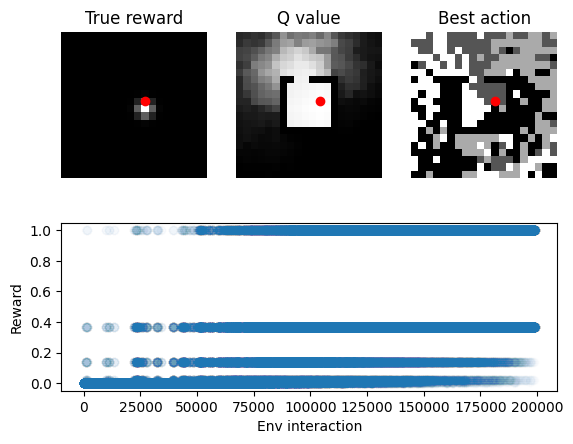

Greediness: 0.985042579200607


In [9]:
#Create new env with estimated reward and train agent
new_env = grid_env()
newQ = value_iteration(new_env,iters=200000,alpha=0.5,gamma=0.99,final_greediness=0.99,eps_anneal=True,disp=True,plot_freq=1000)


In [ ]:
# takes in the env, Q table, episode length
# plays one episode
# plots the reward and q value for every step. 
def test_value(env,Q,steps=50,disp=True, greediness=0.0):
    state = env.reset()
    xm = [] # state
    rsum = 0 # total reward
    for j in range(steps):
        if np.random.rand() < greediness:
            a = np.argmax(Q[env.N*state[0]+state[1],:])
        else:
            a = np.random.randint(env.action_space.shape[0])

        state,reward = env.step(a)
    
        xm.append(np.copy(state))
        rsum = rsum+reward
        if disp:
            plt.subplot(1,2,1)
            plt.imshow(env.f.T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
            plt.plot(env.xl,env.yl,'gx') # goal location
            plt.title('Actual reward')
            plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1],'c-o')
            plt.plot(env.state[0],env.state[1],'ro') # agent location
            plt.axis('off')

            plt.subplot(1,2,2)
            plt.imshow(np.max(Q,axis=1).reshape(env.N,env.N).T, origin="lower",extent=[0,env.N,0,env.N], cmap='gray')
            plt.plot(env.xl,env.yl,'gx') # goal location
            plt.title('Q estimate')
            plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1],'c-o')
            plt.plot(env.state[0],env.state[1],'ro') # agent location
            plt.axis('off')
            plt.title("Q value")

            display.clear_output(wait=True)
            plt.show()
    return rsum, xm

In [ ]:
# Test agent on original world
rsum,traj = test_value(new_env,newQ,steps=40,disp=True, greediness=0.8)